Some aims & notes:

- Need to de-trend/de-season data, since we saw a gradual overall rise in ridership as the bikeshare programme became more established.
- Categorical difference between day type (holiday, working day) is important
- Weather factors also important
- Collapse across registered/casual ridership (as we need to predict the number of bikes that need to be made available for hire, which is agnostic as to which rider type the bikes are rented by)

## Step 0: import packages and data

In [247]:
import pandas as pd
import numpy as np

from statsmodels.api import OLS, add_constant

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline

import warnings
warnings.filterwarnings('ignore')

In [47]:
import pandas as pd

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.feature_selection import RFE

from sklearn.dummy import DummyRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures

from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer

from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

In [61]:
df_raw = pd.read_csv('./data/train_bike_engineered.csv')

## Step 1: train-test split

Splitting at this stage to ensure no contamination of test data.

In [62]:
# get earliest and latest date in data set -- useful for later
print('earliest date is: ' + df_raw['datetime'].min())
print('latest date is: ' + df_raw['datetime'].max())

earliest date is: 2011-01-01 00:00:00
latest date is: 2012-12-19 23:00:00


In [63]:
# get datetime info into index, sort by index
# do this prior to train-test split to ensure no misalignment between X and y data

df_raw.set_index('datetime', inplace=True)
df_raw.sort_index(inplace=True)

In [290]:
y = df_raw['count']

X = df_raw.drop(['count', 'registered', 'casual'], axis = 1)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((8164, 15), (2722, 15), (8164,), (2722,))

In [291]:
X.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'temp_bins', 'atemp_bins', 'wind_bins', 'hour',
       'date', 'month', 'year'],
      dtype='object')

## Step 2: Determining how to deal with time series information

### a. Identifying time trends

Question: Is time a factor in bike counts? If so, we need to take this into account.

Start by fitting linear and quadratic timesteps to the original data. 

In [292]:
Xtrain['timestep'] = np.arange(1, len(Xtrain)+1)
Xtrain['quad_timestep'] = np.arange(1, len(Xtrain)+1)**2

In [293]:
time_X = add_constant(Xtrain['timestep'])
time_Xsq = add_constant(Xtrain[['timestep', 'quad_timestep']])

In [294]:
time_model_linear = OLS(ytrain, time_X)

In [295]:
time_result_linear = time_model_linear.fit()
time_result_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.515
Date:                Tue, 12 Jan 2021   Prob (F-statistic):              0.218
Time:                        18:45:03   Log-Likelihood:                -53998.
No. Observations:                8164   AIC:                         1.080e+05
Df Residuals:                    8162   BIC:                         1.080e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        186.4191      3.994     46.674      0.000     178.590     194.248
timestep       0.0010      0.001      1.231      0.218      -0.001       0.003
==============================================================================
Omnibus:                     1556.069   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2690.522
Skew:                           1.244   Prob(JB):                         0.00
Kurtosis:                       4.309   Cond. No.                     9.43e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.43e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [296]:
time_model_quad = OLS(ytrain, time_Xsq)

In [297]:
time_result_quad = time_model_quad.fit()
time_result_quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9584
Date:                Tue, 12 Jan 2021   Prob (F-statistic):              0.384
Time:                        18:45:04   Log-Likelihood:                -53998.
No. Observations:                8164   AIC:                         1.080e+05
Df Residuals:                    8161   BIC:                         1.080e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           189.2505      5.992     31.582      0.000     177.504     200.997
timestep         -0.0010      0.003     -0.306      0.760      -0.008       0.006
quad_timestep  2.548e-07   4.02e-07      0.634      0.526   -5.33e-07    1.04e-06
==============================================================================
Omnibus:                     1556.251   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2690.985
Skew:                           1.245   Prob(JB):                         0.00
Kurtosis:                       4.310   Cond. No.                     8.95e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.95e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Outcome:**

Neither the linear nor the quadratic timestep have statistically significant p-values in the OLS model, which allows us to veer away from autoregressive models for the analysis.

For the sake of curiosity, let's nonetheless plot the trend & seasonality.

In [298]:
ytrain_diff = ytrain.diff()

In [299]:
ytrain_diff.head()

datetime
2012-10-12 07:00:00      NaN
2011-04-08 17:00:00   -244.0
2012-04-17 04:00:00   -139.0
2011-02-04 19:00:00     94.0
2011-11-03 07:00:00    189.0
Name: count, dtype: float64

### b. Dealing with seasonality (just for visualisation purposes)

Let's plot the volatility by looking at percent changes in count from hour to hour.

Outcome: it looks like there's quite a bit of seasonality -- I'll smoothe this out by subtracting the daily mean from each count.

In [300]:
ytrain_pct = ytrain_diff.pct_change()

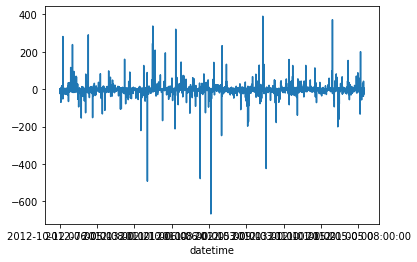

In [301]:
ytrain_pct.plot()

In [302]:
ytrain_dailymean = ytrain_pct.groupby('datetime').transform('mean')

In [303]:
ytrain_deseasoned = ytrain_diff - ytrain_dailymean

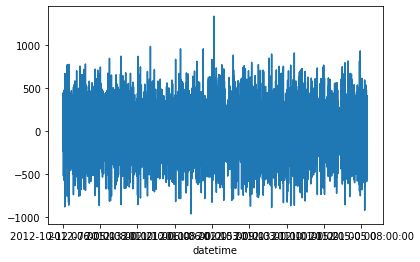

In [304]:
ytrain_deseasoned.plot()

In [305]:
Xtrain.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'temp_bins', 'atemp_bins', 'wind_bins', 'hour',
       'date', 'month', 'year', 'timestep', 'quad_timestep'],
      dtype='object')

## Step 3: Feature reduction and feature engineering

Feature reduction:
- An important modelling assumption: absence of multi-colinearity!
- We saw in the EDA that the temp and atemp (felt temperature) are highly correlated. According to the data documentation, atemp is a measure that takes windspeed and humidity into account. But these are already encoded in separate features.
- So I'm going to drop atemp (and atemp_bins, which I derived from it).
- We have just over a year's worth of data, so `year` won't have predictive power -- will drop this too.
- `date` does not have explanatory power but it's possible the day of the week (e.g. Monday, Wednesday, Sunday etc) will -- create a new column and drop the old date column
- Hypothesis: From the EDA we know that there are huge peaks in ridership around rush hour, i.e. between 7-11 am and 4-7 pm on work days. So I'll create a new feature `rush` to see if this can capture anything useful.
- Housekeeping: since `timestep` and `quad_timestep` were shown not to affect `count` in the OLS model above, let's drop these too.

Feature engineering:

- One-hot encode categorical features
- Date isn't so interesting, but day of the week is
- For continuous features, scale them (and apply the same scale to test data -- must make sure that there's no alteration of the scale based on values from the test data set)

In [306]:
def make_rush_hour(data):
    conditions = [
        (data['hour'] >= 7) & (data['hour'] <= 11) & (data['workingday'] == 1),
        (data['hour'] >= 16) & (data['hour'] <= 19) & (data['workingday'] == 1)]
    choices = ['rush', 'rush']
    data['rush'] = np.select(conditions, choices, default='nonrush')
    return data

In [307]:
# drop features we don't want
# only Xtrain has timestep features -- remove separately

Xtrain = Xtrain.drop(['timestep', 'quad_timestep'], axis=1)

In [308]:
def get_weekday(data):
    '''
    Get day of week from date
    '''
    data['day_of_week'] = pd.to_datetime(data['date']).dt.weekday
    return data

In [309]:
def drop_feat(data):
    '''
    Drops unnecessary features; putting this in a function for easy reproducibility with test data.
    '''
    data = data.drop(['atemp', 'atemp_bins', 'year', 'temp_bins', 'wind_bins', 'date'], axis=1)
    return data

In [310]:
Xtrain = make_rush_hour(Xtrain)
Xtrain = get_weekday(Xtrain)
Xtrain = drop_feat(Xtrain)

In [321]:
Xtest_prep = make_rush_hour(Xtest)
Xtest_prep = get_weekday(Xtest)
Xtest_prep = drop_feat(Xtest)

In [322]:
Xtrain.columns, Xtest_prep.columns

(Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'humidity',
        'windspeed', 'hour', 'month', 'rush', 'day_of_week'],
       dtype='object'),
 Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'humidity',
        'windspeed', 'hour', 'month', 'day_of_week', 'rush'],
       dtype='object'))

In [323]:
scale_categories = ['weather', 'temp', 'humidity', 'windspeed']

In [324]:
onehot_categories = [column for column in Xtrain.columns if column not in scale_categories]

### Preprocessing pipelines

In [325]:
onehot_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

scale_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [326]:
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', onehot_transformer, onehot_categories),
        ('scaler', scale_transformer, scale_categories)
    ])

In [327]:
Xtrain_prep = preprocessor.fit_transform(Xtrain)
Xtest_prep = preprocessor.fit_transform(Xtest)

In [166]:
Xtrain_prep.shape, Xtest_prep.shape

((8164, 55), (2722, 55))

### Double checking

I want to double check that the scaling is working. **tl;dr** yes, it does

In [229]:
to_scale = Xtrain.drop(onehot_categories, axis=1)

In [231]:
scale_only = ColumnTransformer(
    transformers=[
        ('scaler', scale_transformer, scale_categories)
    ])

In [237]:
scale_prep = pd.DataFrame(scale_only.fit_transform(to_scale))

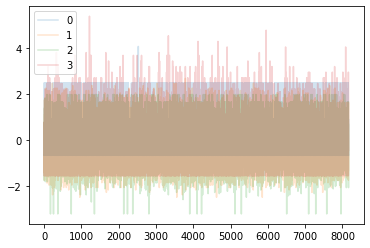

In [241]:
scale_prep.plot(alpha=0.2)

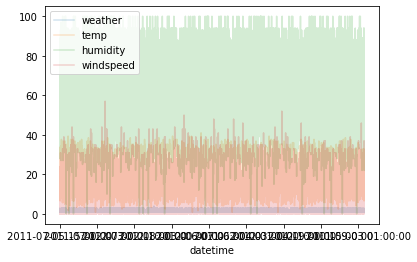

In [242]:
to_scale.plot(alpha=0.2)

## Step 4: Train model

In [328]:
m_lin = LinearRegression()

m_lin.fit(Xtrain_prep, ytrain)

LinearRegression()

In [329]:
m_lin.score(Xtest_prep, ytest)

0.6577254503405352

This initial model performs relatively poorly. Let's start by plotting residuals to check for hidden factors in the error terms.

Residuals are the difference between the predicted value and the actual value.

In [330]:
ypred = m_lin.predict(Xtrain_prep)
resid = ypred - ytrain

In [331]:
y_vals = pd.concat([resid.reset_index(), pd.Series(ypred), ytrain.reset_index().drop(['datetime'], axis=1)], axis=1)
y_vals.columns = ['datetime', 'residuals', 'y_predicted', 'y_true']
y_vals = y_vals.set_index('datetime')

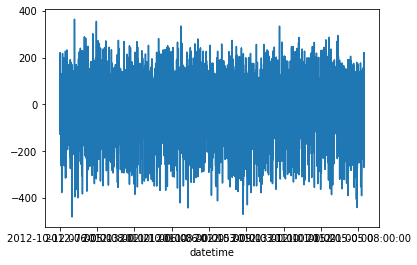

In [332]:
y_vals['residuals'].plot()

**This reveals two problems:**

- The model is predicting negative bike rentals.
- The residuals are uniformly distributed.

In [333]:
ridge = Ridge()

ridge.fit(Xtrain_prep, ytrain)

ridge.score(Xtest_prep, ytest), ridge.score(Xtrain_prep, ytrain)

(0.6577731800015254, 0.6656607784005586)

The good news is that the model isn't overfitting. The bad news is that it's a terrible model.

### Recursive Feature Elimination

Focus on just those features that will enhance the model.

In [248]:
rfe = RFE(ridge)
rfe.fit(Xtrain_prep, ytrain)

RFE(estimator=Ridge())

In [250]:
rfe.support_, rfe.ranking_

(array([False, False, False,  True, False, False, False, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False,  True,  True, False,  True,  True,  True,  True,
         True,  True, False,  True,  True, False, False, False, False,
         True, False,  True,  True,  True, False, False, False, False,
        False, False, False, False, False, False, False,  True,  True,
        False]),
 array([ 2, 21,  9,  1, 28, 27, 29, 25,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  6, 11,  1,  1,  4,  1,  1,  1,  1,  1,  1,  3,  1,  1,  7, 12,
        23, 20,  1, 19,  1,  1,  1, 14, 16, 15, 17, 18, 26, 24, 22, 10,  8,
         5,  1,  1, 13]))

In [254]:
# Slice out those features that are less important in the model; retrain

Xtrain_sliced = Xtrain_prep[:, rfe.support_]
Xtest_sliced = Xtest_prep[:, rfe.support_]

In [256]:
ridge_slice = Ridge()

ridge_slice.fit(Xtrain_sliced, ytrain)

ridge_slice.score(Xtest_sliced, ytest), ridge_slice.score(Xtrain_sliced, ytrain)

(0.6104286161591697, 0.629961332365549)

As a result of separating out the most promising feature, we actually get a worse model.

### GridSearchCV

Let's see if we can improve by doing some grid searching to find the most suitable hyperparameters.

In [257]:
parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}
grid = GridSearchCV(m_lin, parameters, cv=None)
grid.fit(Xtrain_prep, ytrain)

GridSearchCV(estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]})

In [258]:
grid.best_params_

{'fit_intercept': True, 'normalize': True}

In [259]:
grid.best_score_

0.6336522645374025

Minor improvement... but this is not really doing much.